In [3]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import time
from datetime import datetime
import matplotlib.pyplot as plt

### 기본배경
1. 개인 참여자의 관심 지표 => 해당 종목 하루 게시글 개수, 장 시간 동안(09:00-16:00) 시간당 평균 글 리젠 개수, 장 시간 외 시간당 평균 글 리젠 개수
2. 관심도와 주가의 상관관계 => 관심 지표는 저점과 고점을 알려주는 지표로서 활용 가능한가?
3. 실험기간은 작년 3월 ~ 올해 4월 어느때

### 절차
1. 자료수집 selenium => 일단 kospi 200대 기업 + JR 글로벌리츠
2. 관심지표와 주가 비교
3. 다른 지표와 비교


### 향후 계획
1. 제목에 대한 k-clustering을 한번해보고 싶다.


In [ ]:
codes_df = pd.read_excel('data/codes.xlsx')
codes_df['종목코드'] = [format(code,'06') for code in codes_df['종목코드']]
codes_df

In [ ]:
headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36'}

### 2022-04-24 대덕전자부터 시작하면 된다.
for code, name in zip(codes_df['종목코드'], codes_df['종목명']) :
    print(f'종목코드 : {code} || 종목명 : {name}')
    b = 0
    while True :
        time.sleep(0.5)
        b += 1
        u = b*10
        url = f'https://finance.naver.com/item/board.naver?code={code}&page={u}'
        result = requests.get(url,headers=headers)
        soup = BeautifulSoup(result.text, 'html.parser')
        k = soup.find('span','tah p10 gray03')
        print(b,'',u,'',datetime.strptime(k.get_text(),'%Y.%m.%d %H:%M'))
        if  datetime.strptime('2021.03.01 00:00','%Y.%m.%d %H:%M') > datetime.strptime(k.get_text(),'%Y.%m.%d %H:%M') :
            break

    list_data = []
    list_id = []
    for i in range(1,u+1) : 
        if i % 5 == 0 :
            time.sleep(0.11)
        url = f'https://finance.naver.com/item/board.naver?code={code}&page={i}'
        result = requests.get(url,headers=headers)
        soup = BeautifulSoup(result.text, 'html.parser')
        a = soup.find_all('span','tah p10 gray03')
        data = [i.get_text() for i in a][0::2]
        list_data.extend(data)

        b = soup.find_all('td','p11')
        i_d = [re.sub('\s','',i.get_text()) for i in b][0:-1]
        list_id.extend(i_d)

    print(len(list_data),len(list_id),list_data[-1])
    total = pd.DataFrame([list_data,list_id]).T
    total.to_csv(f'data/{name}_posts.csv')

In [ ]:
total.columns = ['datetime','id']
total['datetime'] = pd.to_datetime(total['datetime'])
total['day']= total['datetime'].dt.day
total['month']= total['datetime'].dt.month
total['year']= total['datetime'].dt.year
total['date']= total['datetime'].dt.time
# total.drop(columns='datetime',inplace=True)
te = total.set_index('datetime')
te

In [286]:
BM = (te.index > '2021-03-01') & (te.index < '2022-04-01')
len(BM)
a = te[BM].between_time('08:00','16:00')
b = te[BM].between_time('16:00','23:59')

In [287]:
sol = pd.read_excel('hanwha_solution.xlsx', date_parser=True)
sol.set_index('일자',inplace=True)
BM = (sol.index > '2021-03-01') & (sol.index < '2022-04-01')
sol_time = sol[BM]['종가']

In [288]:
c = a.reset_index().groupby(pd.Grouper(key='datetime',freq='1D')).size()
a = pd.concat([c[sol_time.index],sol_time],axis=1)
a.columns = ['count', 'price']

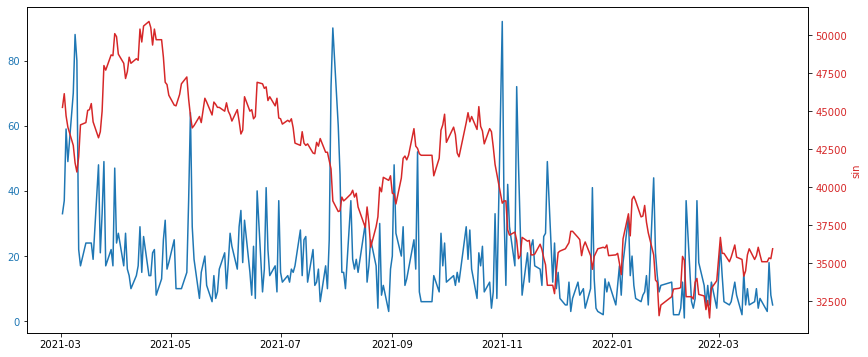

In [312]:
# c = c/7
fig, ax1 = plt.subplots(figsize=(14,6))
color = 'tab:blue'
ax1.plot(a['count'],color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(a['price'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# JR 글로벌 리츠

In [341]:
headers = {'User-Agent':'Mozilla/5.0 (Windows NT 6.3; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/63.0.3239.132 Safari/537.36'}

b = 0
code=348950
while True :
    time.sleep(0.5)
    b += 1
    u = b*50
    url = f'https://finance.naver.com/item/board.naver?code={code}&page={u}'
    result = requests.get(url,headers=headers)
    soup = BeautifulSoup(result.text, 'html.parser')
    k = soup.find('span','tah p10 gray03')
    print(b,'',u,'',datetime.strptime(k.get_text(),'%Y.%m.%d %H:%M'))
    if  datetime.strptime('2021.03.01 00:00','%Y.%m.%d %H:%M') > datetime.strptime(k.get_text(),'%Y.%m.%d %H:%M') :
        break


list_data = []
list_id = []
for i in range(1,u+1) : 
    if i % 5 == 0 :
        time.sleep(0.11)
    url = f'https://finance.naver.com/item/board.naver?code={code}&page={i}'
    result = requests.get(url,headers=headers)
    soup = BeautifulSoup(result.text, 'html.parser')
    a = soup.find_all('span','tah p10 gray03')
    data = [i.get_text() for i in a][0::2]
    list_data.extend(data)

    b = soup.find_all('td','p11')
    i_d = [re.sub('\s','',i.get_text()) for i in b][0:-1]
    list_id.extend(i_d)

print(len(list_data),len(list_id),list_data[-1])
total = pd.DataFrame([list_data,list_id]).T
total.to_csv('JR_reply.csv')

1  50  2021-04-09 13:42:00
2  100  2020-08-07 08:47:00
1742 1742 2020.08.07 08:07


In [314]:
total = pd.DataFrame([list_data,list_id]).T
total.columns = ['datetime','id']
total['datetime'] = pd.to_datetime(total['datetime'])
total['day']= total['datetime'].dt.day
total['month']= total['datetime'].dt.month
total['year']= total['datetime'].dt.year
total['date']= total['datetime'].dt.time
# total.drop(columns='datetime',inplace=True)
te = total.set_index('datetime')
te

,id,day,month,year,date
datetime,,,,,
2022-04-23 13:37:00,kksa****,23,4,2022,13:37:00
2022-04-22 17:50:00,myba****,22,4,2022,17:50:00
2022-04-22 12:14:00,kksa****,22,4,2022,12:14:00
2022-04-22 12:46:00,las1****,22,4,2022,12:46:00
2022-04-22 11:48:00,kksa****,22,4,2022,11:48:00
...,...,...,...,...,...
2020-08-07 08:12:00,whdt****,7,8,2020,08:12:00
2020-08-07 08:11:00,gghl****,7,8,2020,08:11:00
2020-08-07 08:10:00,ckda****,7,8,2020,08:10:00


In [333]:
BM = te.index > '2021-03-01'
# BM = (te.index > '2021-03-01') & (te.index < '2022-04-01')
len(BM)
a = te[BM]
b = te[BM].between_time('08:00','16:00')
c = te[BM].between_time('16:00','23:59')


In [334]:
sol = pd.read_excel('JR.xlsx', date_parser=True)
sol.set_index('일자',inplace=True)
BM = sol.index > '2021-03-01'
sol_time = sol[BM]['종가']
sol_time

일자
2022-04-22    5800
2022-04-21    5810
2022-04-20    5820
2022-04-19    5790
2022-04-18    5780
              ... 
2021-03-08    5180
2021-03-05    5190
2021-03-04    5190
2021-03-03    5200
2021-03-02    5190
Name: 종가, Length: 285, dtype: int64

In [335]:
c = a.reset_index().groupby(pd.Grouper(key='datetime',freq='1D')).size()
sol_time

일자
2022-04-22    5800
2022-04-21    5810
2022-04-20    5820
2022-04-19    5790
2022-04-18    5780
              ... 
2021-03-08    5180
2021-03-05    5190
2021-03-04    5190
2021-03-03    5200
2021-03-02    5190
Name: 종가, Length: 285, dtype: int64

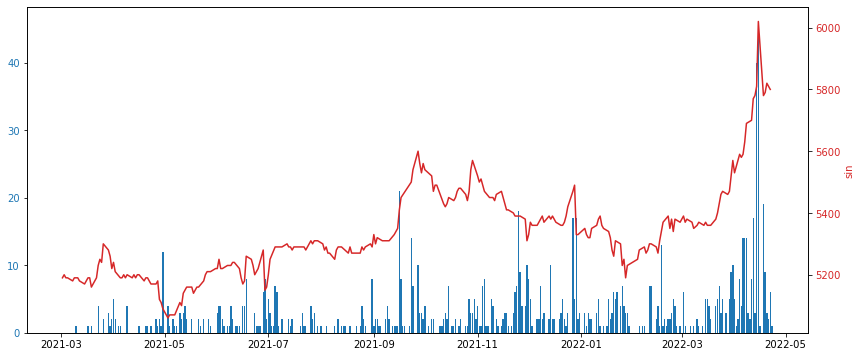

In [336]:
# c = c/7
fig, ax1 = plt.subplots(figsize=(14,6))
color = 'tab:blue'
ax1.bar(c.index,height=c,color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('sin', color=color)  # we already handled the x-label with ax1
ax2.plot(sol_time, color=color)
ax2.tick_params(axis='y', labelcolor=color)